# LIGO - Gravitational Waves Detectability

### What am I looking for?
1. High interpretability $\to$ no PCA (there is physics behind features!)
2. Feature importance - *which variables matter most for disciminating signals in detectable and non detectable ones?*
3. Boundary - *Where does the boundary between classes stand?*
5. TPR --> *how likely is it using this model to classify a detectable signal as such?*
6. FPR --> *how likely is it using this model to classify a non-detectable signal as a detectable one?*
7. TNR --> *how likely is it using this model to classify a non-detectable signal as a such?*
8. FNR --> *how likely is it using this model to classify a detectable signal as a non-detectable one?*

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings

Load downsampled data

In [2]:
y = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\y_ds_100k.npy")

In [3]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\data_ds_100k.npy")

In [4]:
keys = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\keys.npy")

Preprocess data : split for training and validation $\oplus$ standardization

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
S_train = StandardScaler().fit_transform(X_train)
S_test  = StandardScaler().fit_transform(X_test)

Train the classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

Try with random hyperparameters

In [12]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(S_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
def completeness_contamination(y_true, y_pred, positive_label=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, positive_label]).ravel()
    
    completeness = tp / (tp + fn) if (tp + fn) else 0
    contamination = fp / (tp + fp) if (tp + fp) else 0
    TNR = tn / (tn + fp) if (tn + fp) else 0
    
    return completeness, contamination, TNR

In [14]:
completeness, contamination, TNR = completeness_contamination(y_test, clf.predict(S_test))

In [ ]:
print(f'completeness  : {completeness:.2}')
print(f'contamination : {contamination:.2}')
print(f'TNR           : {TNR:.2}')

completeness  : 0.85
contamination : 0.092
TNR           : 0.99


Now cross validation...

In [66]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

custom_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define distributions or lists
param_dist = {
    'n_estimators': randint(10, 50, 100),
    'max_depth': randint(5, 10, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}


In [67]:
clf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=10,             # Number of parameter combinations to try
    cv=5,                  # Cross-validation folds
    scoring='roc_auc',     # or 'roc_auc' if imbalanced
    n_jobs=-1,             # Use all CPUs
    verbose=3,
    random_state=42
)

In [68]:
from sklearn.utils import resample
X_sub, y_sub = resample(X_train, y_train, n_samples=20000, random_state=42)

In [ ]:
y_sub.sum()/len(y_sub)

In [70]:
random_search.fit(X_sub, y_sub)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023913EBA830>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023913F302D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023913EFF250>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023913EBA780>},
                   random_state=42, scoring='roc_auc', verbose=3)

In [71]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 121}
Best score: 0.9920949765580691


In [72]:
clf = random_search.best_estimator_
clf.fit(S_train, y_train)

RandomForestClassifier(max_depth=28, n_estimators=121, random_state=42)

In [74]:
completeness, contamination, TNR = completeness_contamination(y_test, clf.predict(S_test))

print(f'completeness  : {completeness:.2}')
print(f'contamination : {contamination:.2}')
print(f'TNR           : {TNR:.2}')

completeness  : 0.85
contamination : 0.092
TNR           : 0.99


Completeness is descretely high and contamination is more then decently low, good news!\
This means that:
1. Of the "really detectable" signals, the model missed $15\%$ of the true positives $\to$ of a 1000 true positives, I'll miss 150 
2. Of the signals identified as detectables, less then $10\%$ are in reality non detectable (contaminants)
3. Of the signals identified as non detectables, $99\%$ are really non detectables signals

In [75]:
y_pred = clf.predict_proba(S_test)

In [77]:
y_pred_test = clf.predict(S_test)
y_prob_test = clf.predict_proba(S_test)[:, 1]  # for ROC/AUC

# Classification metrics
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_test))


[[16810   254]
 [  438  2498]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17064
           1       0.91      0.85      0.88      2936

    accuracy                           0.97     20000
   macro avg       0.94      0.92      0.93     20000
weighted avg       0.96      0.97      0.96     20000

ROC AUC Score: 0.9922238473750368


Accuracy of $99\%$ is super high! I've answered to points 4-5-6-7

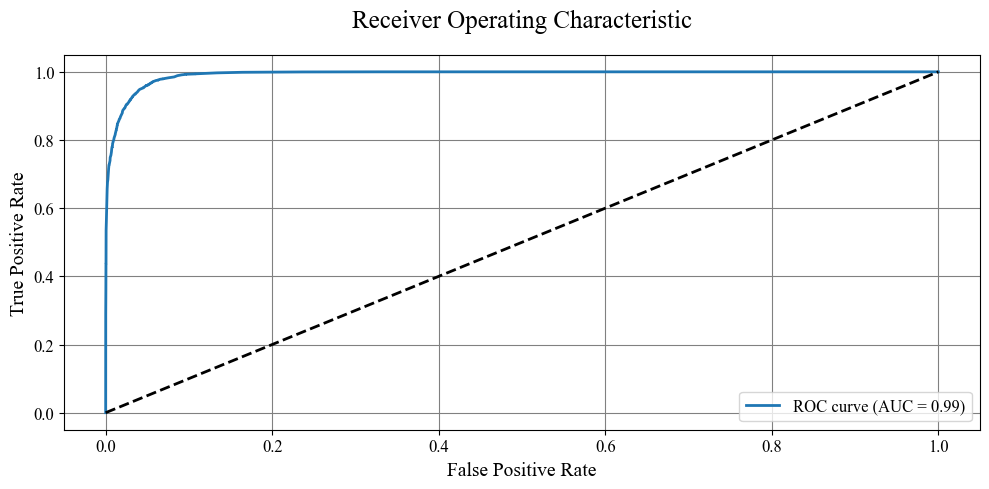

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_prob_test):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.grid(True)
plt.show()

To answer to point 2 about feature importance, I'll look at the *importance* of features.\
Namely, the average on the number of decision trees of the impurity decreases coused by the splits

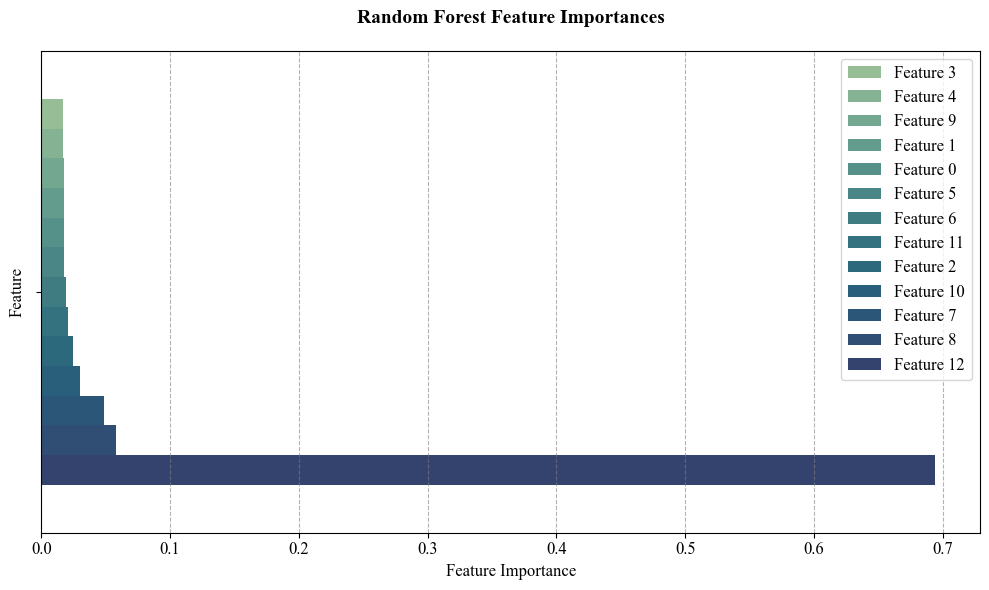

In [79]:
# Example: Replace with your actual values
importances = clf.feature_importances_
feature_names = [f"Feature {i}" for i in range(len(importances))]

# Sort by importance
sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, hue=sorted_names, palette="crest")

plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Random Forest Feature Importances", fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Looks like feature number $12$ is **extremely important**! This feature is $z$ i.e. **redshift**!\
Let's confirm this computing correlation between labels and features.

In [80]:
# Quick correlation check
import pandas as pd
df = pd.DataFrame(data, columns=[f"Feature {i}" for i in range(data.shape[1])])
df["Label"] = y
print(df.corr()["Label"].sort_values(ascending=False))

Label         1.000000
Feature 10    0.055813
Feature 2     0.051166
Feature 5     0.012977
Feature 0     0.004043
Feature 3     0.002559
Feature 7     0.002090
Feature 6     0.001588
Feature 9    -0.000936
Feature 4    -0.001998
Feature 11   -0.002303
Feature 1    -0.003520
Feature 8    -0.005061
Feature 12   -0.580357
Name: Label, dtype: float64


Ok, feature 12 is negatively correlated to the labels! This means that as redshift increases detectability lowers...it makes perfect sense for the classifier to say it's more probable for GWs signals to be detected if they are not very far away!\
This also means that this feature is THE feature to use for discrimination between det and non-det signals.

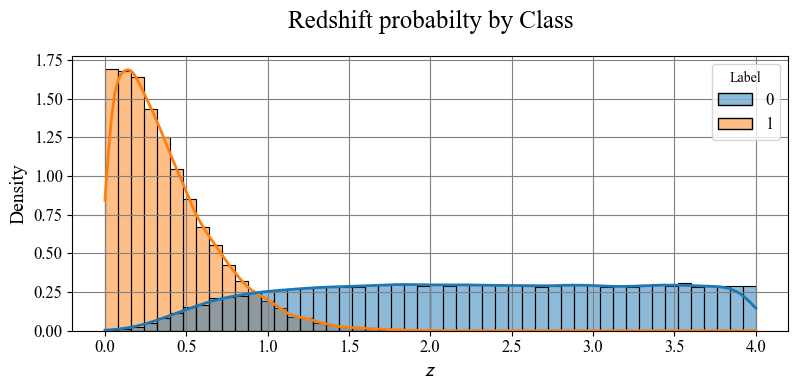

In [81]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Feature 12', hue="Label", bins=50, kde=True, stat="density", common_norm=False)
plt.title("Redshift probabilty by Class")
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

I can compute now a threshold based on what my goal is...
 - If I want to be extremely certain that what I have in my signal is not noise, then I'll use a very low threshold, paying extremely low contamination with pretty low completeness
 - If I just want to  get high statistics, I'll have to accept a higher contamination. I do not like contamination either way :)

In [82]:
z = data[:, 12]
thresholds = np.linspace(z.min(), z.max(), 500)

best = None

for t in thresholds:
    y_pred = (z < t).astype(int)
    comp, cont, _ = completeness_contamination(y, y_pred)
    if best is None or (comp > best[1] and cont < 0.1):  # puoi regolare la soglia max di contaminazione
        best = (t, comp, cont)

print(f"Best redshift th: z < {best[0]:.3f}")
print(f"Completeness    :  {best[1]:.3f}")
print(f"Contamination   : {best[2]:.3f}")

Best redshift th: z < 0.369
Completeness    :  0.580
Contamination   : 0.095


Just to confirm my analysis, what would happen if redshift data were not available?

In [85]:
# Remove Feature 12
X_reduced = np.delete(data, 12, axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, stratify=y, random_state=42)

# Train and evaluate
clf = random_search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate your metrics
completeness, contamination, TNR = completeness_contamination(y_test, y_pred)

print(f"Without Feature 12:")
print(f"  Completeness:  {completeness:.3f}")
print(f"  Contamination: {contamination:.3f}")
print(f"  TNR:           {TNR:.3f}")


Without Feature 12:
  Completeness:  0.002
  Contamination: 0.600
  TNR:           0.999


I'd have very scarse chances to discriminate between detectable and non detectable signals!